<a href="https://colab.research.google.com/github/tomdaler/Machine-Learning/blob/main/Time%20Series/TimeSeriesByYear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install skforecast

     |████████████████████████████████| 87 kB 3.1 MB/s 
     |████████████████████████████████| 76 kB 2.1 MB/s 
     |████████████████████████████████| 9.8 MB 40.5 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.63.0
    Uninstalling tqdm-4.63.0:
      Successfully uninstalled tqdm-4.63.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from skforecast.model_selection import grid_search_forecaster


In [ ]:
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Warnings configuration
import warnings
warnings.filterwarnings('ignore')


In [ ]:
url = 'time_serie.csv'
data = pd.read_csv(url, sep=',')

# Data preparation
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')

data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Verify that a temporary index is complete
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

# Fill gaps in a temporary index
# data.asfreq(freq='30min', fill_value=np.nan)


True

In [ ]:
# Split data into train-test. Last 36 months are for test
steps = 36
data_train = data[:-steps]  # BLUE
data_test  = data[-steps:]  # RED

forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), 
                                              Lasso(random_state=123)),
                    steps     = 36,
                    lags      = 8
                )

param_grid = {'lasso__alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]


Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:24<00:00,  8.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'lasso__alpha': 0.021544346900318846}
  Backtesting metric: 0.010608155083112462



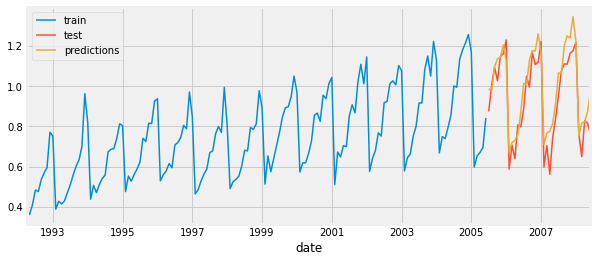

In [ ]:
results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        param_grid  = param_grid,
                        lags_grid = lags_grid,
                        steps       = 36,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

predictions = forecaster.predict()

fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();


In [ ]:
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")


Test error (mse) 0.009726551142140267


In [ ]:
# Create and train forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg

forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
                )

forecaster.fit(y=data_train['y'])



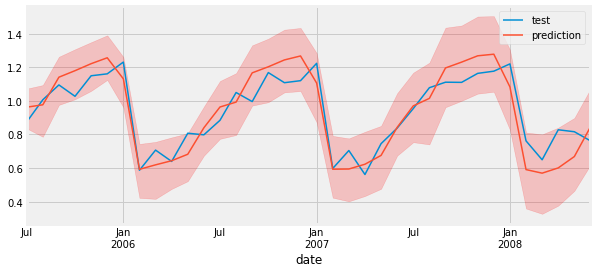

In [ ]:
# Prediction intervals
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
              )

fig, ax=plt.subplots(figsize=(9, 4))
data_test['y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();


In [ ]:
# Backtest with prediction intervals
# ==============================================================================
n_val = 36*3
data_train = data[:-n_val]
data_val  = data[-n_val:]

steps = 36
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Lasso(alpha=0.0215)),
                lags = 15
            )

from skforecast.model_selection import backtesting_forecaster
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['y'],
                            initial_train_size = len(data_train),
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                       )

print(f"Test error (mse): {error_mse}")


Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00

Test error (mse): 0.009726551142140267


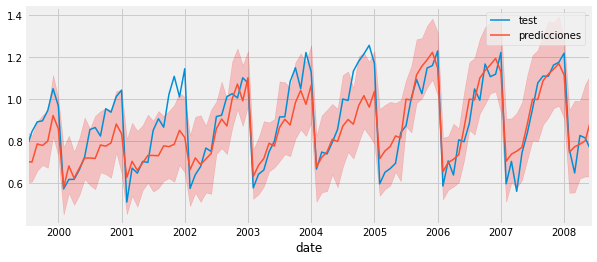

In [ ]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_val['y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();
